### **Load libraries**

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import risk_kit as rk
import importlib

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as sts
from mgarch import mgarch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### **Load data**

In [4]:
rets = pd.read_csv('selected_stocks_rets.csv', index_col=0)
stocks = pd.read_csv('selected_stocks_stocks.csv', index_col=0)

rets.index = pd.to_datetime(rets.index).to_period('D')
stocks.index = pd.to_datetime(stocks.index).to_period('D')

In [5]:
# Define the number of periods per year for all calculations
# 252 is an approximation for daily
# 54 for weekly
# 12 for monthly
periods_per_year = 252

# **Estimation of future Moving Average Returns**

### **Analysis of stationarity**

In [6]:
# Define a window size for the calculation of Moving Average Returns
# Previous analysis suggests that 63 days for a rolling window is a good number for models
# It also comes from dividing 252 days by 4, to get the average number of days per month
window_size = 63

In [7]:
# Analysis of stationarity for the whole series\
# The results suggest that the series behaves as white noise so there aren't strong signs of current values depending on previous values
for stock in rets.columns:
    print(f'Augmented Dickey Fuller Test p-value for non-stationarity of level {stock} series: {round(adfuller(rets[stock].rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1).dropna())[1], 4)}')

Augmented Dickey Fuller Test p-value for non-stationarity of level BCOLOMBIA.CL series: 0.0611
Augmented Dickey Fuller Test p-value for non-stationarity of level BHI.CL series: 0.0338
Augmented Dickey Fuller Test p-value for non-stationarity of level BOGOTA.CL series: 0.0718
Augmented Dickey Fuller Test p-value for non-stationarity of level BVC.CL series: 0.1791
Augmented Dickey Fuller Test p-value for non-stationarity of level CELSIA.CL series: 0.232
Augmented Dickey Fuller Test p-value for non-stationarity of level CNEC.CL series: 0.0177
Augmented Dickey Fuller Test p-value for non-stationarity of level CORFICOLCF.CL series: 0.1655
Augmented Dickey Fuller Test p-value for non-stationarity of level EXITO.CL series: 0.012
Augmented Dickey Fuller Test p-value for non-stationarity of level GEB.CL series: 0.1922
Augmented Dickey Fuller Test p-value for non-stationarity of level GRUBOLIVAR.CL series: 0.0304
Augmented Dickey Fuller Test p-value for non-stationarity of level GRUPOARGOS.CL se

In [8]:
# Visualize MA returns for some stocks
# rets['CEMARGOS.CL'].rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1).plot()

## **OLS on moving average returns**

We model the average returns of the last 21 days as a function of the average returns and average volatility of the 12 months before it.

In [9]:
def ols_ma_df(stock, data, window_size=30, num_lag_windows=1, params=['mean']):
    model_df = data[[stock]].copy()
    model_df[f'MA{window_size}_L{0}'] = model_df[stock].rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1)
    for i in range(num_lag_windows+1):
        if 'mean' in params and i != 0:
            model_df.loc[:, f'MA{window_size}_L{i}'] = model_df[stock].shift(i*window_size).rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1)
            model_df.loc[:, f'MA{window_size}_L{i}_squared'] = model_df[f'MA{window_size}_L{i}']**2
            model_df.loc[:, f'MA{window_size}_L{i}_cubed'] = model_df[f'MA{window_size}_L{i}']**3
        if 'stddev' in params and i != 0:
            model_df.loc[:, f'MStdDev{window_size}_L{i}'] = model_df[stock].shift(i*window_size).rolling(window_size).std(ddof=0)
    model_df.dropna(inplace=True)
    endog = model_df[f'MA{window_size}_L0']
    exog = model_df.drop(columns=[f'MA{window_size}_L0', stock])
    return endog, exog

In [10]:
def ols_ma_rets(stock, data, window_size=30, num_lag_windows=1, params=['mean']):
    endog, exog = ols_ma_df(stock, data, window_size, num_lag_windows, params)
    model = sm.OLS(endog=endog,
                   exog=sm.add_constant(exog)).fit()
    return model

In [11]:
def ols_ma_predict(model, stock, data, window_size=30, num_lag_windows=1, params=['mean'], plot=False):
    endog, exog = ols_ma_df(stock, data, window_size, num_lag_windows, params)
    confidence_intervals = model.conf_int()
    lower_bound = (model_df * confidence_intervals.iloc[:, 0]).sum(axis=1)
    upper_bound = (model_df * confidence_intervals.iloc[:, 1]).sum(axis=1)
    preds = model.predict(model_df)

    if plot==True:
        plt.figure(figsize=(10, 5))
        # data[stock][-60:].plot(color='black', label='Actual returns')
        # data[stock].rolling(21).mean()[-60:].plot(color='blue', label=f'Actual MA{window_size}')
        preds.plot(color='orange', label=f'Predicted MA{window_size}')
        lower_bound.plot(color='grey', linestyle='--')
        upper_bound.plot(color='grey', linestyle='--')
        plt.legend()
        plt.grid(alpha=.3)
        plt.show()
        
    return preds, lower_bound, upper_bound

In [12]:
def ols_ma_predict_test_set(model, stock, train_set, test_set, window_size=30, num_lag_windows=1, params=['mean'], plot=False):
    data = pd.concat([train_set, test_set], axis=0)
    endog, exog = ols_ma_df(stock, data, window_size, num_lag_windows, params)
    exog = sm.add_constant(exog)
    confidence_intervals = model.conf_int()
    lower_bound = (exog * confidence_intervals.iloc[:, 0]).sum(axis=1)
    upper_bound = (exog * confidence_intervals.iloc[:, 1]).sum(axis=1)
    preds = model.predict(sm.add_constant(exog))

    if plot==True:
        plt.figure(figsize=(10, 5))
        data[stock][-60:].plot(color='black', label='Actual returns')
        data[stock].rolling(window_size).apply(lambda x: pd.Series(x+1).prod()**(1/window_size) - 1)[-60:].plot(color='blue', label=f'Actual MA{window_size}')
        preds.loc[test_set.index.min():].plot(color='orange', label=f'Predicted MA{window_size}')
        lower_bound[test_set.index.min():].plot(color='grey', linestyle='--')
        upper_bound[test_set.index.min():].plot(color='grey', linestyle='--')
        plt.legend()
        plt.grid(alpha=.3)
        plt.show()
        
    return preds, lower_bound, upper_bound, exog

### **Model test predicting the last 2 months**

In [13]:
# Generate train, validation and test sets to evaluate the accuracy of the model
# 1st The model will be modeled based on the train data initially
# 2nd The model will be fine tuned based on accuracy results with the validation set
# 3rd it will be evaluated with the test set

train_set = rets.loc[: '2024-12'].copy()
test_set = rets.loc['2025-01':].copy()

In [15]:
# Examine the results 
window_size = 63
model_test = ols_ma_rets('PFGRUPSURA.CL', train_set, window_size=window_size, num_lag_windows=6, params=['mean', 'stddev'])
print(model_test.summary())

                            OLS Regression Results                            
Dep. Variable:                MA63_L0   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     103.4
Date:                Wed, 05 Mar 2025   Prob (F-statistic):          1.09e-109
Time:                        14:45:49   Log-Likelihood:                 1430.7
No. Observations:                 257   AIC:                            -2811.
Df Residuals:                     232   BIC:                            -2723.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0225      0.007     

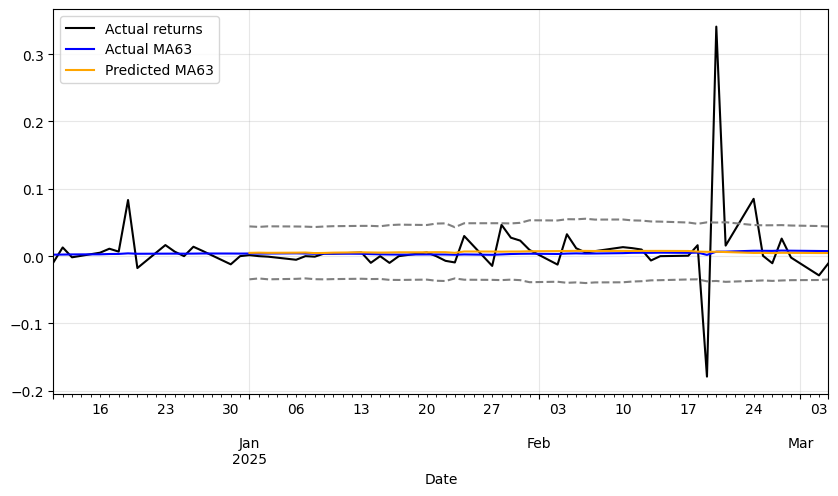

In [17]:
preds = ols_ma_predict_test_set(model_test, 'PFGRUPSURA.CL', train_set, test_set, window_size=window_size, num_lag_windows=6, params=['mean', 'stddev'], plot=True)

# **Predictions**

In [18]:
expected_annualized_rets = {}

# Generate train and test sets to find the best model for each stock
prediction_days = 63
train_set = rets.iloc[:-prediction_days]
test_set = rets.iloc[-prediction_days:]

window_size = 63
num_lag_windows = [l+1 for l in range(10)]

# Iterate over each stock
for stock in rets.columns:
    # Initialize an empty dictionary to store scores
    rmse = {}
    # Calculate the RMSE for a naive prediction against which other predictions will be compared
    naive = train_set[stock][-520:]
    naive_rets = (1 + naive).prod()**(1/len(naive)) - 1
    naive_rmse = np.sqrt(np.mean((test_set - naive_rets)**2))

    # Iterate over each amount of lag windows
    for i in range(1, 10):
        # Fit the model with the corresponding num_lag_windows parameter for the iteration
        model = ols_ma_rets(stock, train_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
        # Make predictions based on the test set we already have
        preds_actuals = ols_ma_predict_test_set(model, stock, train_set, test_set, window_size=window_size, num_lag_windows=i, params=['mean', 'stddev'])
        preds = preds_actuals[0][-prediction_days:]

        # Compare the predictions with the observed values
        rmse[i] = np.sqrt(np.mean((test_set[stock] - preds)**2))
    # Identify the best number of lags to use based on the RMSE
    best_lag_windows = pd.Series(rmse).idxmin()
    best_rmse = rmse[best_lag_windows]
    if best_rmse < naive_rmse:
        # If there was an RMSE better than the naive one, then make predictions with that model specification
        # First fit the model with all the data for the stock
        model = ols_ma_rets(stock, rets, window_size=window_size, num_lag_windows=best_lag_windows, params=['mean', 'stddev'])

        # Make a df with 63 future dates for the preprocessing function
        df_for_predict = rets.copy()
        future_dates = pd.date_range(start=df_for_predict.index.max().to_timestamp() + pd.Timedelta(days=1), periods=prediction_days)
        future_df = pd.DataFrame(index=future_dates, columns=rets.columns, data=0).to_period('D')
        df_for_predict = pd.concat([df_for_predict, future_df], axis=0)
        df_for_predict = sm.add_constant(ols_ma_df(stock, df_for_predict, window_size=window_size, num_lag_windows=best_lag_windows, params=['mean', 'stddev'])[1])
        # Compute the predictions
        future_preds = model.predict(df_for_predict)
        preds = (1 + future_preds[-1])**periods_per_year - 1
        # Extract the predictions for the average returns of the future days and store it in expected_daily_rets
        expected_annualized_rets[stock] = preds
    else:
        # If the models don't seem to perform better than just taking the returns from the last n days based on the analysis window
        historical = rets[stock][-520:]
        historical_rets = rk.annualize_returns(historical, periods_per_year=periods_per_year)
        expected_annualized_rets[stock] = historical_rets
        

C:\Users\jumar\AppData\Local\Temp\ipykernel_35616\1835564372.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preds = (1 + future_preds[-1])**periods_per_year - 1
C:\Users\jumar\AppData\Local\Temp\ipykernel_35616\1835564372.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preds = (1 + future_preds[-1])**periods_per_year - 1
C:\Users\jumar\AppData\Local\Temp\ipykernel_35616\1835564372.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.i

In [19]:
pd.Series(expected_annualized_rets)

BCOLOMBIA.CL     0.184854
BHI.CL           0.434538
BOGOTA.CL        0.138840
BVC.CL          -0.592973
CELSIA.CL        0.459294
CNEC.CL         -0.218733
CORFICOLCF.CL    0.307341
EXITO.CL        -0.451946
GEB.CL           0.479725
GRUBOLIVAR.CL   -0.575973
GRUPOARGOS.CL    0.676780
GRUPOAVAL.CL     0.120975
GRUPOSURA.CL     0.133806
HCOLSEL.CL       1.675121
ICOLCAP.CL       0.651210
ISA.CL           0.109233
MINEROS.CL       0.632634
NUTRESA.CL       0.511525
PFAVAL.CL        0.084774
PFBCOLOM.CL      0.290756
PFCORFICOL.CL   -0.080434
PFDAVVNDA.CL    -0.245234
PFGRUPOARG.CL    0.696537
PFGRUPSURA.CL    0.886135
PROMIGAS.CL      0.364825
TERPEL.CL        0.496801
AAPL             0.281553
BRK-B            0.455940
CBU7.L           0.158586
CENCOSUD.SN      1.205745
CHILE.SN         0.294171
F               -0.312682
FALABELLA.SN     0.038733
ISAC.CL         -0.433938
JNJ             -0.283731
JPEA.CL          0.597482
NKE             -0.178274
PFE             -0.232255
SDHA.CL     

In [ ]:
# https://www.youtube.com/watch?v=mm0DA8zgHIs

### **Covariance matrix estimation**

In [20]:
"""
# Simple long-term covariance
covmat = rets.cov()
returns = summary_stats['Annualized Return']
"""

"\n# Simple long-term covariance\ncovmat = rets.cov()\nreturns = summary_stats['Annualized Return']\n"

In [21]:
summary_stats = rk.summary_stats(rets, periods_per_year=periods_per_year, riskfree_rate=0)
returns = summary_stats['Annualized Return']

# Recent covariance prediction based on recent days with GARCH model
vol = mgarch('t')
vol.fit(rets)
ndays = 63
covmat = vol.predict(ndays)
covmat = pd.DataFrame(data=covmat['cov'], index=returns.index, columns=returns.index)

### **Export predicted returns and covariance matrix**

In [22]:
pd.Series(expected_annualized_rets).to_csv('expected_returns.csv', header=None)

In [23]:
covmat.to_csv('expected_covmat.csv')